In [24]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_curve, auc
import warnings

# Suppress pandas setting with copy warnings
warnings.filterwarnings('ignore')

# Configuration
PROCESSED_DIR = '/kaggle/input/2dgpaddedfeats' # Adjust paths as necessary
SUBMISSION_DIR = '.'
RANDOM_SEED = 42

print("Libraries loaded.")

Libraries loaded.


In [25]:
def load_data(path):
    try:
        print(f"Loading data from {path}...")
        train = pd.read_parquet(f'{path}/2dgp_train_features.parquet')
        test = pd.read_parquet(f'{path}/2dgp_mallorn_test_features.parquet')
        print(f"Train Shape: {train.shape}")
        print(f"Test Shape: {test.shape}")
        return train, test
    except FileNotFoundError:
        print("ERROR: Parquet files not found. Check paths.")
        return None, None

train_df, test_df = load_data(PROCESSED_DIR)

Loading data from /kaggle/input/2dgpaddedfeats...
Train Shape: (3043, 290)
Test Shape: (7135, 289)


In [26]:
def engineer_interaction_features(df):
    df = df.copy()
    
    # --- 1. Cooling Physics (SN vs TDE) ---
    # Rate of color change (Reddening per day)
    # If this is High -> Likely SN. If Near Zero -> Likely TDE.
    df['physics_cooling_rate_gr'] = df['gp_color_gr_evolution'] / (df['gp_decline_duration_g'] + 1e-5)
    df['physics_cooling_rate_ug'] = df['gp_color_ug_evolution'] / (df['gp_decline_duration_u'] + 1e-5)
    
    # --- 2. IR Lag (SN Ia Detection) ---
    # Lag between UV peak and IR peak. 
    # SNe Ia have a "secondary max" in IR that causes a delay.
    if 'gp_peak_time_u' in df.columns and 'gp_peak_time_z' in df.columns:
        df['physics_peak_lag_uz'] = df['gp_peak_time_z'] - df['gp_peak_time_u']
    
    # --- 3. Shape Fill Factor (Power Law vs Exponential) ---
    # Proxy for "Area under curve". 
    # TDEs (Power Law) have "fatter" tails than SNe (Exponential).
    for band in ['g', 'r']:
        df[f'physics_shape_fill_{band}'] = df[f'Flux_mean_{band}'] / (df[f'Flux_max_{band}'] + 1e-5)
        
    # --- 4. Luminosity Ratios (UV Dominance) ---
    # TDEs are UV bright. SNe are often UV faint.
    total_flux_proxy = df['Flux_max_g'] + df['Flux_max_r'] + df['Flux_max_i']
    df['physics_uv_fraction'] = df['Flux_max_u'] / (total_flux_proxy + 1e-5)
    
    # --- 5. AGN Stochasticity (Signal-to-Noise of Variability) ---
    # Is the variance real (AGN) or just noise?
    # Uses Excess Variance proxy
    for band in ['g', 'r']:
        df[f'physics_excess_var_{band}'] = (df[f'Flux_std_{band}']**2 - df[f'Flux_err_mean_{band}']**2)
        
    return df

def select_features(df, features_to_keep=None):
    """
    Filters dataframe to keep only selected features.
    """
    if features_to_keep:
        # Ensure preserved columns exist in df
        cols = [c for c in features_to_keep if c in df.columns]
        return df[cols]
    return df

# --- CONFIGURATION ---
# Set this to False to keep ALL generated features
USE_MANUAL_SELECTION = False 
# ---------------------

# Define feature list (Based on your original notebook)
manual_features_list = [
    # --- 1. THE PHYSICS "SUPER FEATURES" (MUST HAVE) ---
    # These discriminate the classes based on mechanism
    'decay_model_ratio',           # TDE (Power Law) vs SN (Exponential)
    'bazin_mse',                   # SN (Low Error) vs AGN (High Error)
    'stetson_j',                   # AGN (High Variability) vs Transients
    'physics_color_cooling_rate',  # SN (Cools/Reddens) vs TDE (Constant Blue)

    # --- 2. TOP GAIN WINNERS (MORPHOLOGY) ---
    # From your importance plot
    'gp_wavelength_scale',         # Coherence across bands (High for SN/TDE)
    'gp_peak_value_z',             # Secondary Max detection (Key for SN Ia)
    'Flux_skew_g', 'Flux_skew_r',  # Asymmetry (TDEs are highly skewed)
    'gp_time_scale',               # Duration of the event
    'gp_peak_timing_spread',       # Do all bands peak at once? (TDE=Yes, AGN=No)

    # --- 3. LUMINOSITY (DISTANCE CORRECTED) ---
    # Better than raw Flux
    'Flux_Z_Scaled_r',             # Proxy for Absolute Magnitude
    'Flux_Z_Scaled_g',
    'Flux_Max_Z_Scaled_z',         # IR Luminosity (SN discriminator)
    'Z',                           # Redshift is fundamental context

    # --- 4. COLOR & CORRELATION ---
    'gp_corr_gz',                  # Green-Infrared correlation
    'gp_corr_uz',                  # UV-Infrared correlation (Extreme ends)
    'gp_color_ug_early',           # Color at peak (TDEs are very negative/blue here)
    'gp_color_gr_early',
    'gp_color_ug_evolution',       # How color changes over time

    # --- 5. DERIVATIVES (RISE & FALL) ---
    'gp_rise_duration_g',          # Fast rise (TDE) vs Slower rise (SN)
    'gp_decline_duration_g',       # Long tail (TDE) vs Linear tail (SN)
    'gp_deriv_std_z',              # Smoothness in IR
    'gp_asymmetry_ratio_r',        # Rise Time / Fall Time

    # --- 6. OBSERVATIONAL CONTEXT ---
    # Helps model handle noisy data
    'gp_uncertainty_mean_u',       # Proxy for "Faintness" in UV
    'gp_log_likelihood',           # How well did the GP fit overall?
    'gp_noise_level',              
    
    # --- 7. RELEVANT LAGS (AGN Specific) ---
    'gp_structure_function_lag10_u', # Long-term variability characteristic
]


train_df = engineer_interaction_features(train_df)
test_df = engineer_interaction_features(test_df)

print("Added physics interaction features.")
print(f"New Shape: {train_df.shape}")

# Determine which features to use based on the flag
if USE_MANUAL_SELECTION:
    print("Applying manual feature selection...")
    final_features = manual_features_list
else:
    print("Keeping all features (excluding ID and Target)...")
    # Get all columns except non-feature columns
    cols_to_exclude = ['object_id', 'target']
    final_features = [c for c in train_df.columns if c not in cols_to_exclude]

# Keep IDs and Target separately
train_ids = train_df['object_id']
train_y = train_df['target']

# Select features for X (Train and Test)
train_X = select_features(train_df, final_features)
test_X = select_features(test_df, final_features)

test_ids = test_df['object_id']

print(f"Feature selection mode: {'Manual List' if USE_MANUAL_SELECTION else 'All Available'}")
print(f"Final Train Feature Shape: {train_X.shape}")

feature_cols = train_X.columns.tolist()
print(feature_cols)

Added physics interaction features.
New Shape: (3043, 298)
Keeping all features (excluding ID and Target)...
Feature selection mode: All Available
Final Train Feature Shape: (3043, 296)
['Flux_mean_g', 'Flux_mean_i', 'Flux_mean_r', 'Flux_mean_u', 'Flux_mean_y', 'Flux_mean_z', 'Flux_max_g', 'Flux_max_i', 'Flux_max_r', 'Flux_max_u', 'Flux_max_y', 'Flux_max_z', 'Flux_min_g', 'Flux_min_i', 'Flux_min_r', 'Flux_min_u', 'Flux_min_y', 'Flux_min_z', 'Flux_std_g', 'Flux_std_i', 'Flux_std_r', 'Flux_std_u', 'Flux_std_y', 'Flux_std_z', 'Flux_skew_g', 'Flux_skew_i', 'Flux_skew_r', 'Flux_skew_u', 'Flux_skew_y', 'Flux_skew_z', 'Flux_err_mean_g', 'Flux_err_mean_i', 'Flux_err_mean_r', 'Flux_err_mean_u', 'Flux_err_mean_y', 'Flux_err_mean_z', 'Time (MJD)_duration_g', 'Time (MJD)_duration_i', 'Time (MJD)_duration_r', 'Time (MJD)_duration_u', 'Time (MJD)_duration_y', 'Time (MJD)_duration_z', 'Time (MJD)_count_g', 'Time (MJD)_count_i', 'Time (MJD)_count_r', 'Time (MJD)_count_u', 'Time (MJD)_count_y', 'Time (

Starting 5-Fold Cross-Validation (CatBoost)...
0:	test: 0.7899827	best: 0.7899827 (0)	total: 61.8ms	remaining: 2m 3s
100:	test: 0.9521013	best: 0.9533103 (75)	total: 4.43s	remaining: 1m 23s
200:	test: 0.9612550	best: 0.9622913 (160)	total: 8.73s	remaining: 1m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9622913069
bestIteration = 160

Shrink model to first 161 iterations.
Fold 1 complete. Best Iteration: 160
0:	test: 0.7971215	best: 0.7971215 (0)	total: 59.6ms	remaining: 1m 59s
100:	test: 0.9384571	best: 0.9384571 (100)	total: 4.37s	remaining: 1m 22s
200:	test: 0.9501439	best: 0.9502015 (197)	total: 8.76s	remaining: 1m 18s
300:	test: 0.9559585	best: 0.9559585 (300)	total: 13s	remaining: 1m 13s
400:	test: 0.9591249	best: 0.9591825 (396)	total: 17.3s	remaining: 1m 9s
500:	test: 0.9624640	best: 0.9624640 (500)	total: 21.7s	remaining: 1m 4s
600:	test: 0.9648244	best: 0.9651698 (595)	total: 26.1s	remaining: 1m
700:	test: 0.9664364	best: 0.9664940 (694)	total: 30.

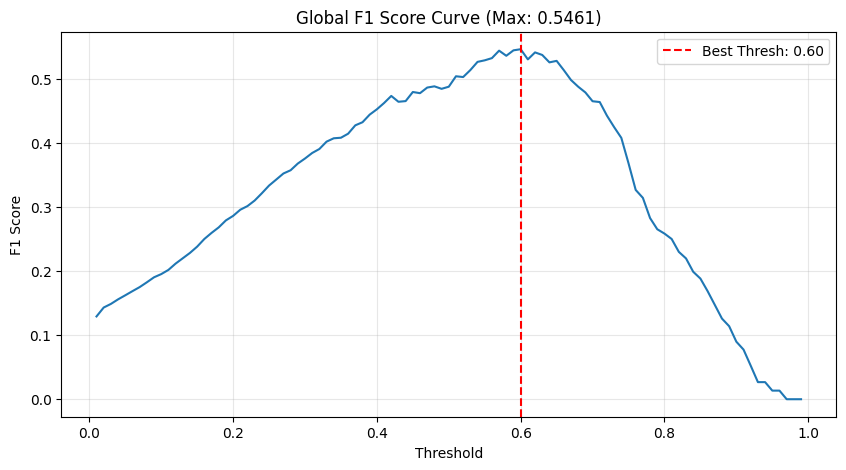


--- OOF Classification Report (Threshold: 0.60) ---
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2895
           1       0.53      0.56      0.55       148

    accuracy                           0.95      3043
   macro avg       0.75      0.77      0.76      3043
weighted avg       0.96      0.95      0.96      3043



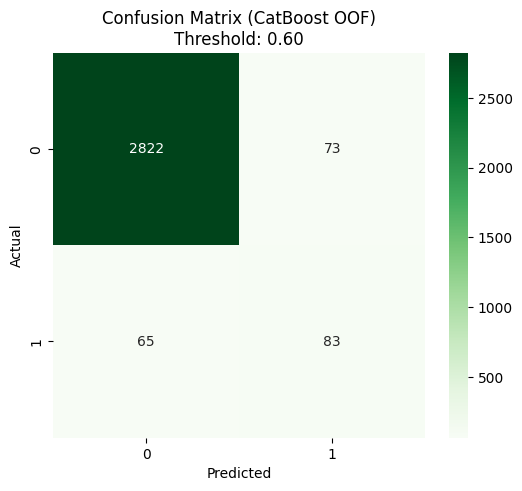

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# --- 1. Define the Threshold Function (Same as before) ---
def find_best_threshold(y_true, y_probs):
    thresholds = np.arange(0.01, 1.00, 0.01)
    f1_scores = []
    
    for thresh in thresholds:
        preds = (y_probs >= thresh).astype(int)
        f1_scores.append(f1_score(y_true, preds))
    
    best_f1 = max(f1_scores)
    best_thresh = thresholds[np.argmax(f1_scores)]
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, f1_scores)
    plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best Thresh: {best_thresh:.2f}')
    plt.title(f"Global F1 Score Curve (Max: {best_f1:.4f})")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return best_thresh, best_f1

# --- 2. Run K-Fold to gather OOF Predictions ---
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Array to store the prediction for every single row in the training set
oof_probs = np.zeros(len(train_X)) 

print(f"Starting {N_FOLDS}-Fold Cross-Validation (CatBoost)...")

cat_models = [] # Store models for test set inference

for fold, (train_idx, val_idx) in enumerate(skf.split(train_X, train_y)):
    # Data Split
    X_train_fold, X_val_fold = train_X.iloc[train_idx], train_X.iloc[val_idx]
    y_train_fold, y_val_fold = train_y.iloc[train_idx], train_y.iloc[val_idx]
    
    # Calculate Weight for this fold
    ratio = (len(y_train_fold) - y_train_fold.sum()) / y_train_fold.sum()
    
    # Define Model
    # Note: CatBoost uses 'depth' (symmetric trees) rather than 'num_leaves'.
    clf = CatBoostClassifier(
        iterations=2000,
        learning_rate=0.01,
        depth=6,                     # Equivalent to max_depth
        l2_leaf_reg=3,               # Regularization (standard default is usually fine, 3 is safe)
        subsample=0.7,               # bagging equivalent (requires bootstrap_type='Bernoulli' or 'MVS')
        bootstrap_type='Bernoulli',  # Needed to use subsample
        scale_pos_weight=ratio,      # Handle Imbalance
        loss_function='Logloss',     # Binary classification objective
        eval_metric='AUC',           # Monitoring metric
        random_seed=56 + fold,
        allow_writing_files=False,   # Keep directory clean (no catboost_info folder)
        verbose=False                # We will handle logging manually via fit
    )
    
    # Train
    clf.fit(
        X_train_fold, y_train_fold,
        eval_set=(X_val_fold, y_val_fold),
        early_stopping_rounds=100,
        verbose=100                  # Log every 100 iterations
    )
    
    # Predict Probability
    # CatBoost predict_proba returns [prob_class_0, prob_class_1]
    valid_probs = clf.predict_proba(X_val_fold)[:, 1]
    oof_probs[val_idx] = valid_probs
    
    cat_models.append(clf)
    
    # Get best iteration
    best_iter = clf.get_best_iteration()
    print(f"Fold {fold+1} complete. Best Iteration: {best_iter}")

# --- 3. Find Best Threshold on the FULL OOF Predictions ---
print("\nCalculating Best Global Threshold...")
best_thresh, best_f1 = find_best_threshold(train_y, oof_probs)

# --- 4. Final Evaluation using that Threshold ---
final_preds = (oof_probs >= best_thresh).astype(int)

print(f"\n--- OOF Classification Report (Threshold: {best_thresh:.2f}) ---")
print(classification_report(train_y, final_preds))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(train_y, final_preds), annot=True, fmt='d', cmap='Greens') # Changed color to Greens for variety
plt.title(f"Confusion Matrix (CatBoost OOF)\nThreshold: {best_thresh:.2f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Total False Negatives (Missed): 65
Top 5 'Most Missed' (Model confident it was 0, but was 1):


,Flux_mean_g,Flux_mean_i,Flux_mean_r,Flux_mean_u,Flux_mean_y,Flux_mean_z,Flux_max_g,Flux_max_i,Flux_max_r,Flux_max_u,...,physics_cooling_rate_ug,physics_peak_lag_uz,physics_shape_fill_g,physics_shape_fill_r,physics_uv_fraction,physics_excess_var_g,physics_excess_var_r,True_Label,Prob,Pred
579,0.076442,0.692777,0.456069,0.212321,0.747469,0.563940,0.568999,2.512943,1.930632,1.190225,...,-0.000037,0.000000,0.134342,0.236226,0.237447,0.034203,0.474136,1,0.026465,0
871,5.120025,4.135275,5.592118,7.116403,3.865092,3.915952,22.660551,15.356343,18.741754,20.317454,...,-0.000121,-64.083441,0.225944,0.298377,0.357962,69.846229,56.514526,1,0.028124,0
1689,3.578938,3.237823,3.558840,1.863550,2.188173,1.352611,9.146260,8.661581,9.299993,7.608634,...,-0.001130,0.000000,0.391300,0.382671,0.280680,14.210673,14.662297,1,0.058589,0
3032,0.570018,0.162571,0.404629,0.123215,0.248212,0.280957,1.359487,1.346627,1.685128,1.357628,...,0.000013,-80.786017,0.419286,0.240116,0.309166,0.282189,0.300090,1,0.088793,0
84,0.510153,0.339494,0.439983,1.353604,0.316935,0.417024,2.424747,1.673080,2.044874,3.085074,...,0.000110,-80.234110,0.210394,0.215163,0.502233,0.943775,0.480489,1,0.094624,0


--------------------------------------------------

Total False Positives (False Alarms): 73
Top 5 'False Alarms' (Model confident it was 1, but was 0):


,Flux_mean_g,Flux_mean_i,Flux_mean_r,Flux_mean_u,Flux_mean_y,Flux_mean_z,Flux_max_g,Flux_max_i,Flux_max_r,Flux_max_u,...,physics_cooling_rate_ug,physics_peak_lag_uz,physics_shape_fill_g,physics_shape_fill_r,physics_uv_fraction,physics_excess_var_g,physics_excess_var_r,True_Label,Prob,Pred
2233,0.645775,0.635265,0.697708,0.602585,0.582868,0.525343,3.099547,2.662097,2.886440,3.251936,...,4.520448e-05,0.0,0.208344,0.241718,0.376029,0.933578,0.957692,0,0.920262,1
1522,0.480051,0.604013,0.331202,0.798339,0.603567,0.566688,3.522365,5.029346,3.704367,2.390983,...,2.418826e-05,0.0,0.136286,0.089408,0.195085,1.405387,0.924430,0,0.875643,1
2269,0.110089,1.112072,0.773793,0.817200,1.408747,0.973892,1.263335,4.972496,4.505801,4.912349,...,8.267617e-06,0.0,0.087141,0.171732,0.457318,0.180417,1.787969,0,0.872782,1
2231,0.237381,0.379871,0.215424,0.284720,0.342543,0.109556,2.610848,1.921933,2.656639,2.481228,...,-9.495816e-05,0.0,0.090921,0.081089,0.345122,0.321037,0.452656,0,0.868390,1
2437,0.113254,0.274578,0.278282,0.095446,0.071465,0.017128,1.681192,2.408798,3.088051,0.774394,...,2.441786e-09,0.0,0.067365,0.090115,0.107884,0.165872,0.739882,0,0.858905,1


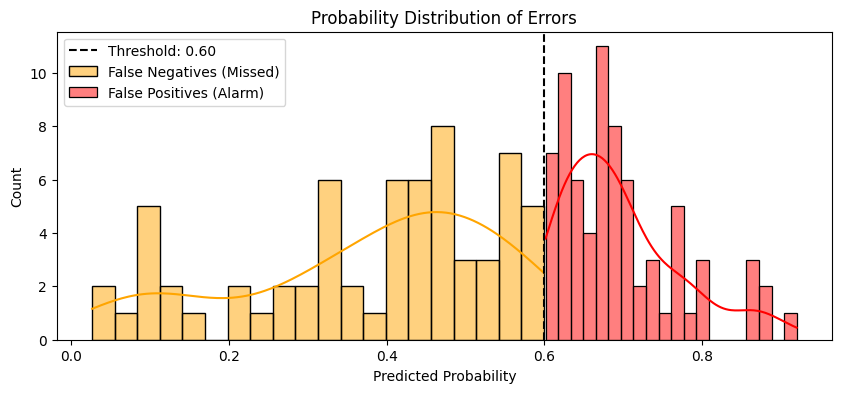

In [28]:
# --- 5. Error Analysis: Most Missed & False Alarms ---

# Create a DataFrame to analyze errors side-by-side with features
analysis_df = train_X.copy()
analysis_df['True_Label'] = train_y
analysis_df['Prob'] = oof_probs
analysis_df['Pred'] = final_preds

# 1. False Negatives (Missed): Actual is 1, Model predicted 0
# We sort by 'Prob' ASCENDING to find the ones the model was "surest" were 0
false_negatives = analysis_df[
    (analysis_df['True_Label'] == 1) & (analysis_df['Pred'] == 0)
].sort_values(by='Prob', ascending=True)

# 2. False Positives (False Alarms): Actual is 0, Model predicted 1
# We sort by 'Prob' DESCENDING to find the ones the model was "surest" were 1
false_positives = analysis_df[
    (analysis_df['True_Label'] == 0) & (analysis_df['Pred'] == 1)
].sort_values(by='Prob', ascending=False)

# --- Print Output ---
print(f"\nTotal False Negatives (Missed): {len(false_negatives)}")
print("Top 5 'Most Missed' (Model confident it was 0, but was 1):")
display(false_negatives.head(5))

print("-" * 50)

print(f"\nTotal False Positives (False Alarms): {len(false_positives)}")
print("Top 5 'False Alarms' (Model confident it was 1, but was 0):")
display(false_positives.head(5))

# Optional: Visualize the distribution of probabilities for errors
plt.figure(figsize=(10, 4))
sns.histplot(false_negatives['Prob'], color='orange', label='False Negatives (Missed)', kde=True, bins=20)
sns.histplot(false_positives['Prob'], color='red', label='False Positives (Alarm)', kde=True, bins=20)
plt.axvline(best_thresh, color='black', linestyle='--', label=f'Threshold: {best_thresh:.2f}')
plt.title("Probability Distribution of Errors")
plt.xlabel("Predicted Probability")
plt.legend()
plt.show()

--- Top 50 Most Important Features (CatBoost Default) ---
                       Feature  Importance_Score
                   Flux_skew_r          5.702781
                   Flux_skew_g          3.759444
           gp_wavelength_scale          3.454476
                   Flux_skew_i          2.264833
gp_wavelength_scale_normalized          2.062182
             gp_smoothed_min_i          2.054761
         gp_peak_timing_spread          1.477280
          physics_shape_fill_r          1.356225
                    Flux_min_g          1.315306
               Flux_Z_Scaled_g          1.217654
             gp_smoothed_min_r          1.171168
         gp_uncertainty_mean_u          1.126484
             gp_smoothed_min_y          0.991148
                 gp_time_scale          0.909806
             gp_smoothed_min_z          0.886114
           Flux_Max_Z_Scaled_u          0.823166
          gp_uncertainty_max_u          0.794576
         gp_uncertainty_mean_z          0.741538
           

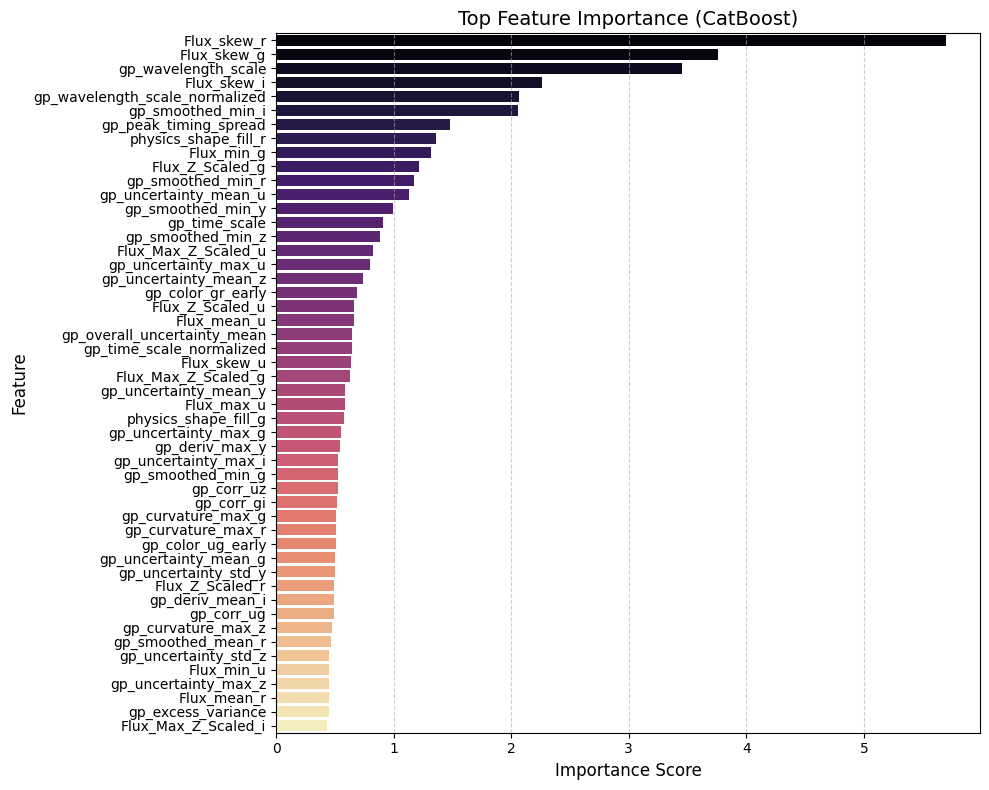

['Feature', 'Importance_Score']


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, CatBoostRegressor

def analyze_feature_importance_catboost(model, feature_names=None, top_n=25):
    """
    Extracts, prints, and plots feature importance from a CatBoost model.
    """
    # 1. Get importance scores
    # CatBoost's default importance type is 'FeatureImportance' (which is similar to Gain/Information Value)
    importance_values = model.get_feature_importance(type='FeatureImportance')
    
    # 2. Handle Feature Names
    # If feature_names is None, try to retrieve them from the model itself
    if feature_names is None:
        if hasattr(model, 'feature_names_'):
            feature_names = model.feature_names_
        else:
            # Fallback if names are missing
            feature_names = [f"Feature_{i}" for i in range(len(importance_values))]
            
    # 3. Create DataFrame
    if len(feature_names) != len(importance_values):
        raise ValueError(f"Feature names length ({len(feature_names)}) does not match model importance length ({len(importance_values)})")
        
    df_imp = pd.DataFrame({
        'Feature': feature_names, 
        'Importance_Score': importance_values
    })
    
    df_imp = df_imp.sort_values(by='Importance_Score', ascending=False).reset_index(drop=True)

    # 4. Print the top N features
    print(f"--- Top {top_n} Most Important Features (CatBoost Default) ---")
    print(df_imp.head(top_n).to_string(index=False))

    # 5. Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance_Score', y='Feature', data=df_imp.head(top_n), palette='magma')
    plt.title('Top Feature Importance (CatBoost)', fontsize=14)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return df_imp

# Usage
# Note: You can pass 'feature_cols' explicitly, or leave it None if the CatBoost model was trained with a DataFrame/Pool with names.
feature_importance_df = analyze_feature_importance_catboost(clf, feature_cols, top_n=50)

print(feature_importance_df.columns.tolist())

Computing correlation matrix for 296 features...
--------------------------------------------------
Starting Greedy Selection (Threshold: 0.9)...

PROCESS COMPLETE:
Original Count: 296
Dropped:        142 (Redundant)
Final Count:    154
--------------------------------------------------

--- Example Redundant Features Dropped ---
                       Dropped       Kept_Substitute  Correlation  Gain_Dropped  Gain_Kept
gp_wavelength_scale_normalized   gp_wavelength_scale     0.997887      2.062182   3.454476
             gp_smoothed_min_r     gp_smoothed_min_i     0.986128      1.171168   2.054761
             gp_smoothed_min_y     gp_smoothed_min_i     0.982136      0.991148   2.054761
             gp_smoothed_min_z     gp_smoothed_min_i     0.994087      0.886114   2.054761
          gp_uncertainty_max_u gp_uncertainty_mean_u     0.996268      0.794576   1.126484


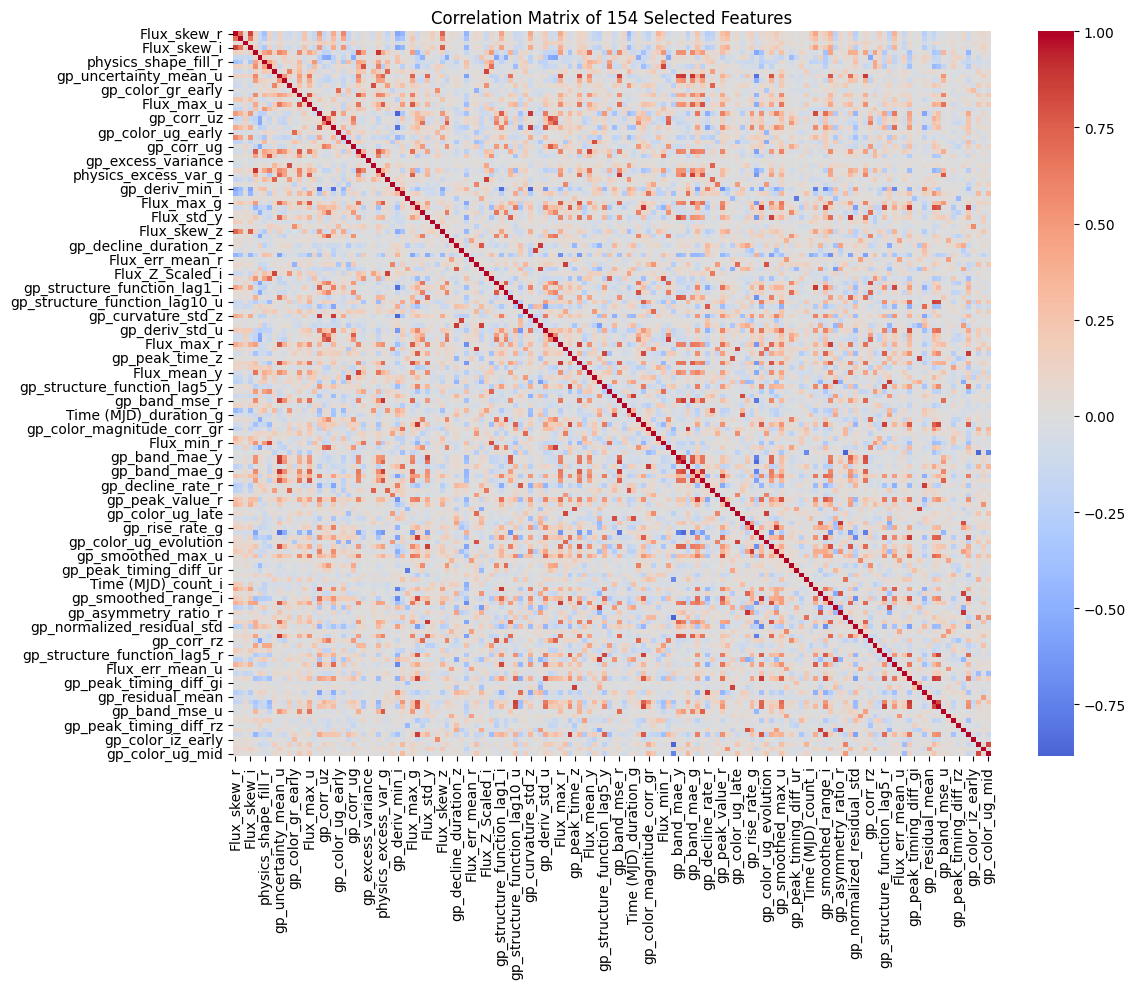


Copy this list for your next model run:
['Flux_skew_r', 'Flux_skew_g', 'gp_wavelength_scale', 'Flux_skew_i', 'gp_smoothed_min_i', 'gp_peak_timing_spread', 'physics_shape_fill_r', 'Flux_min_g', 'Flux_Z_Scaled_g', 'gp_uncertainty_mean_u', 'gp_time_scale', 'Flux_Max_Z_Scaled_u', 'gp_color_gr_early', 'Flux_mean_u', 'Flux_skew_u', 'Flux_max_u', 'physics_shape_fill_g', 'gp_deriv_max_y', 'gp_corr_uz', 'gp_corr_gi', 'gp_curvature_max_g', 'gp_color_ug_early', 'gp_uncertainty_std_y', 'gp_deriv_mean_i', 'gp_corr_ug', 'gp_smoothed_mean_r', 'Flux_min_u', 'gp_excess_variance', 'Flux_Max_Z_Scaled_i', 'gp_smoothed_min_u', 'physics_excess_var_g', 'Flux_Z_Scaled_y', 'physics_cooling_rate_gr', 'gp_deriv_min_i', 'physics_uv_fraction', 'physics_peak_lag_uz', 'Flux_max_g', 'gp_smoothed_std_r', 'gp_corr_ri', 'Flux_std_y', 'gp_residual_kurtosis', 'gp_color_ri_early', 'Flux_skew_z', 'gp_corr_gr', 'Flux_err_mean_g', 'gp_decline_duration_z', 'gp_curvature_mean_i', 'gp_log_likelihood', 'Flux_err_mean_r', 'gp_col

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def select_smart_features(importance_df, train_df, threshold=0.90):
    """
    Selects top features based on Importance Gain, removing those that are 
    highly correlated with a higher-ranked feature already selected.
    
    Args:
        importance_df: DataFrame with ['Feature', 'Gain_Score']
        train_df: The training dataframe (to calculate correlations)
        threshold: Correlation coefficient cutoff (default 0.90)
        
    Returns:
        final_features: List of selected feature names
    """
    
    # 1. Sort features by Importance (Highest Gain first)
    sorted_features = importance_df.sort_values(by='Importance_Score', ascending=False)['Feature'].tolist()
    
    # 2. Calculate Correlation Matrix (only for the relevant columns to save memory)
    # Filter only features present in both lists
    valid_feats = [f for f in sorted_features if f in train_df.columns]
    print(f"Computing correlation matrix for {len(valid_feats)} features...")
    corr_matrix = train_df[valid_feats].corr().abs()
    
    selected_features = []
    dropped_features = []
    
    print("-" * 50)
    print(f"Starting Greedy Selection (Threshold: {threshold})...")
    
    # 3. Iterate through sorted features
    for feature in valid_feats:
        is_redundant = False
        
        # Check correlation with features ALREADY selected
        for selected in selected_features:
            correlation = corr_matrix.loc[feature, selected]
            
            if correlation > threshold:
                is_redundant = True
                dropped_features.append({
                    'Dropped': feature,
                    'Kept_Substitute': selected,
                    'Correlation': correlation,
                    'Gain_Dropped': importance_df.loc[importance_df['Feature'] == feature, 'Importance_Score'].values[0],
                    'Gain_Kept': importance_df.loc[importance_df['Feature'] == selected, 'Importance_Score'].values[0]
                })
                break # Stop checking, we already found a reason to drop it
        
        if not is_redundant:
            selected_features.append(feature)

    # 4. Output Results
    print(f"\nPROCESS COMPLETE:")
    print(f"Original Count: {len(valid_feats)}")
    print(f"Dropped:        {len(dropped_features)} (Redundant)")
    print(f"Final Count:    {len(selected_features)}")
    print("-" * 50)
    
    # Optional: Show what was dropped and why (Top 5 examples)
    if dropped_features:
        drop_df = pd.DataFrame(dropped_features)
        print("\n--- Example Redundant Features Dropped ---")
        print(drop_df.head(5).to_string(index=False))
    
    return selected_features, drop_df if dropped_features else pd.DataFrame()

# --- USAGE ---
# 1. Run the selection
# Assuming 'feature_importance_df' is from the previous step and 'X_train' is your training data
final_feature_list, dropped_info = select_smart_features(feature_importance_df, train_df, threshold=0.90)

# 2. Verify with a Heatmap of ONLY selected features
plt.figure(figsize=(12, 10))
sns.heatmap(train_df[final_feature_list].corr(), cmap='coolwarm', center=0, annot=False)
plt.title(f"Correlation Matrix of {len(final_feature_list)} Selected Features")
plt.tight_layout()
plt.show()

print("\nCopy this list for your next model run:")
print(final_feature_list)

In [31]:
# Predict on full test set
test_probs = clf.predict_proba(test_X)[:, 1]
test_preds = (test_probs >= best_thresh).astype(int)

submission = pd.DataFrame({
    'object_id': test_ids,
    'prediction': test_preds
    # 'probability': test_probs # Optional: save probs if needed for ensemble later
})

filename = f'submission_f1_{best_f1:.4f}.csv'
submission.to_csv(filename, index=False)

print(f"Submission saved: {filename}")
print(f"Predicted TDEs in Test: {submission['prediction'].sum()} out of {len(submission)}")

Submission saved: submission_f1_0.5461.csv
Predicted TDEs in Test: 374 out of 7135
